# Imports

In [1]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, lfilter, freqz, iirnotch

import tensorflow as tf
from tensorflow.keras import layers

# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Disable wrapping
# pd.set_option('display.max_colwidth', None)  # Show full contents of each cell

pd.reset_option('display.max_columns')  # Show all columns
pd.reset_option('display.expand_frame_repr')  # Disable wrapping
pd.reset_option('display.max_colwidth')  # Show full contents of each cell


# Load data


In [2]:
# import os
# import pandas as pd
# import wfdb

# # Load the CSV file
# superclass_df = pd.read_csv('superclass.csv')

# # Initialize empty arrays to store the data
# data = []

# # Specify the root directory
# root_dir = '../ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

# # Loop over all records in the DataFrame
# for idx, row in superclass_df.iterrows():
#     if (idx+1)%100 == 0:
#         print(f"Processing record {idx+1}/{len(superclass_df)}")
#     # Get filename without extension
#     filename = os.path.splitext(row['filename_lr'])[0]

#     # Construct the full path
#     full_path = os.path.join(root_dir, filename)

#     # Load the raw ECG signal data from the .dat file
#     dat, fields = wfdb.rdsamp(full_path)

#     # Load the labels data from the .hea file
#     hea = wfdb.rdheader(full_path)

#     # Add data to the list
#     data.append({
#         'record_name': filename,
#         'superclass': row['diagnostic_superclass'],
#         'signal': dat,
#         'age': row['age'],
#         'sex': row['sex']
#     })

# # Convert the list to a DataFrame
# df = pd.DataFrame(data)

# # Save the DataFrame
# df.to_pickle('df_processed.pkl')

df = pd.read_pickle('df_processed_250.pkl')
df

,record_name,superclass,signal,age,sex
0,records500/00000/00001_hr,['NORM'],"[[-0.08588371897207263, -0.03736346853162483, ...",56.0,1
1,records500/00000/00002_hr,['NORM'],"[[-0.011243299508205044, 0.09023407534582495, ...",19.0,0
2,records500/00000/00003_hr,['NORM'],"[[-0.02596508144425195, -0.052584897690685514,...",37.0,1
3,records500/00000/00004_hr,['NORM'],"[[-0.04137347387754445, -0.11622565135690588, ...",24.0,0
4,records500/00000/00005_hr,['NORM'],"[[-0.03003880948325483, -0.43121334841072106, ...",19.0,1
...,...,...,...,...,...
16239,records500/21000/21833_hr,['STTC'],"[[-0.04391078902957227, -0.02257351658386932, ...",67.0,1
16240,records500/21000/21834_hr,['NORM'],"[[-0.026419722051677138, 0.0036079393377764384...",300.0,0
16241,records500/21000/21835_hr,['STTC'],"[[0.06267955458986217, 0.0552252383461329, -0....",59.0,1
16242,records500/21000/21836_hr,['NORM'],"[[-0.03373067418018933, -0.02617115333028704, ...",64.0,1


# Preprocessing

## downsampling NORM class

In [3]:
# Filter out the "NORM" class

norm_df = df[df['superclass'] == '[\'NORM\']']

# Randomly sample 6000 records from the "NORM" class to be removed
to_remove = norm_df.sample(6000, random_state=1)

# Remove these from the original df
df = df.drop(to_remove.index)
df


,record_name,superclass,signal,age,sex
0,records500/00000/00001_hr,['NORM'],"[[-0.08588371897207263, -0.03736346853162483, ...",56.0,1
2,records500/00000/00003_hr,['NORM'],"[[-0.02596508144425195, -0.052584897690685514,...",37.0,1
7,records500/00000/00008_hr,['MI'],"[[-0.029191385508134767, -0.05611670272285019,...",48.0,0
9,records500/00000/00010_hr,['NORM'],"[[-0.04884232917703562, -0.0901889111153408, -...",22.0,1
11,records500/00000/00012_hr,['NORM'],"[[0.1972585306084939, 0.2603701638378019, 0.06...",43.0,1
...,...,...,...,...,...
16235,records500/21000/21826_hr,['MI'],"[[-0.010193774422008913, 0.01224806477719749, ...",82.0,1
16236,records500/21000/21830_hr,['NORM'],"[[-0.06730370254978757, 0.03782162036429296, 0...",86.0,0
16238,records500/21000/21832_hr,['CD'],"[[-0.05269679238427077, -0.022555283540224205,...",63.0,0
16239,records500/21000/21833_hr,['STTC'],"[[-0.04391078902957227, -0.02257351658386932, ...",67.0,1


## Upsample lowest class

In [4]:
from sklearn.utils import resample

# Separate the 'HYP' class
hyp_df = df[df['superclass'] == '[\'HYP\']']

# Determine how many instances you need to resample
n_samples = 2000  # adjust this value as needed

# Resample the 'HYP' class
hyp_upsampled = resample(hyp_df, 
                         replace=True,  # sample with replacement
                         n_samples=n_samples,  # to match number in majority class
                         random_state=1)  # reproducible results

# Combine the upsampled 'HYP' class with the original dataframe
df = pd.concat([df[df['superclass'] != 'HYP'], hyp_upsampled])
df = df.reset_index(drop=True)


# df = df[df['superclass'] != '[\'HYP\']']

df = df.reset_index(drop=True)
df

,record_name,superclass,signal,age,sex
0,records500/00000/00001_hr,['NORM'],"[[-0.08588371897207263, -0.03736346853162483, ...",56.0,1
1,records500/00000/00003_hr,['NORM'],"[[-0.02596508144425195, -0.052584897690685514,...",37.0,1
2,records500/00000/00008_hr,['MI'],"[[-0.029191385508134767, -0.05611670272285019,...",48.0,0
3,records500/00000/00010_hr,['NORM'],"[[-0.04884232917703562, -0.0901889111153408, -...",22.0,1
4,records500/00000/00012_hr,['NORM'],"[[0.1972585306084939, 0.2603701638378019, 0.06...",43.0,1
...,...,...,...,...,...
12239,records500/11000/11847_hr,['HYP'],"[[-0.00680820774445255, -0.051833156434892516,...",71.0,1
12240,records500/01000/01851_hr,['HYP'],"[[0.07481719516687026, 0.2588313580843357, 0.1...",79.0,1
12241,records500/08000/08766_hr,['HYP'],"[[-0.1089140501363713, -0.19542081519713775, -...",60.0,1
12242,records500/15000/15470_hr,['HYP'],"[[-0.00782561498964344, 0.015039583317178877, ...",72.0,0


## One Hot

In [5]:
# Make sure each label is in a separate list
df['superclass'] = df['superclass'].apply(lambda x: [x] if isinstance(x, str) else x)

mlb = MultiLabelBinarizer()
label_encoded = mlb.fit_transform(df['superclass'])
df_encoded = pd.concat([df.drop('superclass', axis=1), pd.DataFrame(label_encoded, columns=mlb.classes_)], axis=1)

df_encoded


,record_name,signal,age,sex,['CD'],['HYP'],['MI'],['NORM'],['STTC']
0,records500/00000/00001_hr,"[[-0.08588371897207263, -0.03736346853162483, ...",56.0,1,0,0,0,1,0
1,records500/00000/00003_hr,"[[-0.02596508144425195, -0.052584897690685514,...",37.0,1,0,0,0,1,0
2,records500/00000/00008_hr,"[[-0.029191385508134767, -0.05611670272285019,...",48.0,0,0,0,1,0,0
3,records500/00000/00010_hr,"[[-0.04884232917703562, -0.0901889111153408, -...",22.0,1,0,0,0,1,0
4,records500/00000/00012_hr,"[[0.1972585306084939, 0.2603701638378019, 0.06...",43.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
12239,records500/11000/11847_hr,"[[-0.00680820774445255, -0.051833156434892516,...",71.0,1,0,1,0,0,0
12240,records500/01000/01851_hr,"[[0.07481719516687026, 0.2588313580843357, 0.1...",79.0,1,0,1,0,0,0
12241,records500/08000/08766_hr,"[[-0.1089140501363713, -0.19542081519713775, -...",60.0,1,0,1,0,0,0
12242,records500/15000/15470_hr,"[[-0.00782561498964344, 0.015039583317178877, ...",72.0,0,0,1,0,0,0


## Distribution of diseases SNOMED

In [6]:
# plt.figure(figsize=(10, 6))

# # Bar chart
# bars = plt.bar(disease_counts_sorted.index.astype(str), disease_counts_sorted.values)

# # Add data values to the top of the bars
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom')

# plt.xlabel('SNOMED Disease Code')
# plt.ylabel('Number of Patients')
# plt.title('Distribution of Diseases')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()


## test display

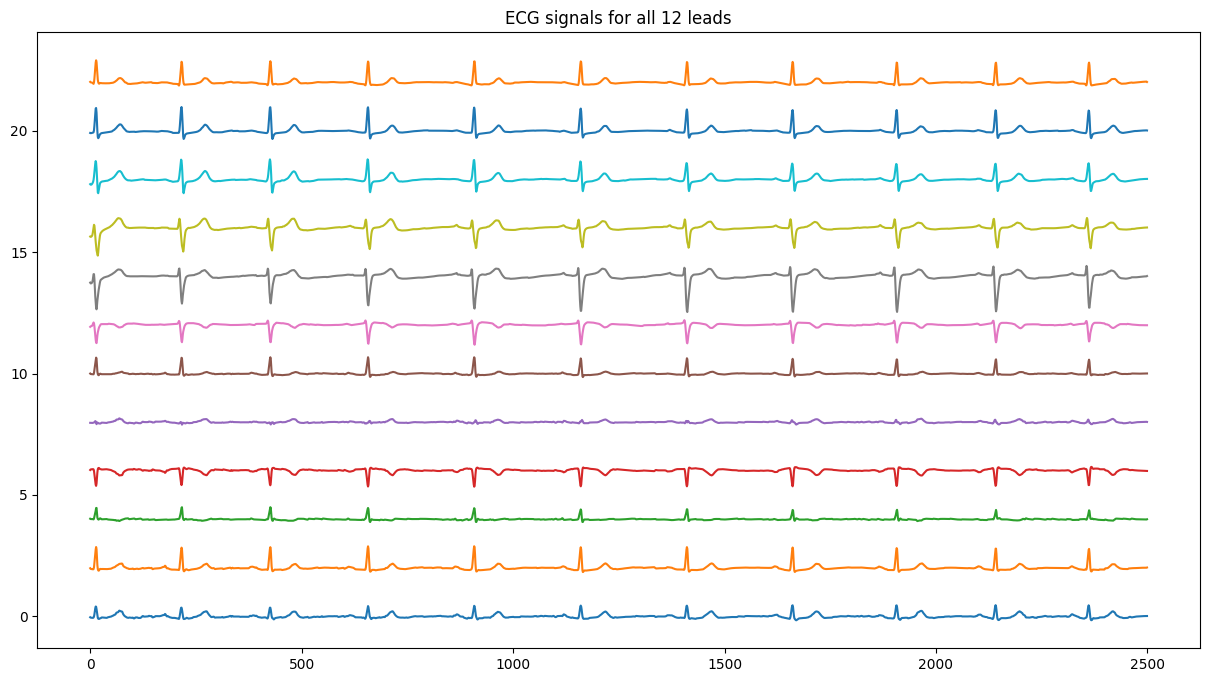

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Create a list to store all ECG signals
all_ecgs = []

# Iterate over the 12 leads
for i in range(12):
    single_ecg = []
    for sublist in df_encoded.loc[3,'signal']:  # Get the data for one patient
        single_ecg.append(sublist[i])  # Get data for one lead

    signals, info = nk.ecg_process(single_ecg, sampling_rate=100)
    cleaned_ecg = signals["ECG_Clean"]

    all_ecgs.append(cleaned_ecg)

# Combine all ECG signals into a single 2D array
all_ecgs = np.stack(all_ecgs)

# Plot each ECG lead with a slight vertical shift for better visibility
for i, ecg in enumerate(all_ecgs):
    plt.plot(ecg + i*2)  # Shift each lead by 200 units

plt.title('ECG signals for all 12 leads')
plt.show()


## Remove last beat if incomplete

In [8]:
# cpt=0
# def clean_heartbeats(row):
#     global cpt
#     all_leads = []
#     for sublist in row['signal']:
#         all_leads.append(sublist)  # Get all leads 

#     # Process lead II to get R-peaks
#     single_ecg_lead_II = [sublist[1] for sublist in row['signal']]  # LEAD II 
#     try:
#         signals, info = nk.ecg_process(single_ecg_lead_II, sampling_rate=100)
#     except ValueError as e:
#         print(f"An error occurred while processing the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     rpeaks = info["ECG_R_Peaks"]
#     # Remove NaN values from rpeaks
#     rpeaks = rpeaks[~np.isnan(rpeaks)]
#     try:
#         heartbeats_II = np.split(single_ecg_lead_II, rpeaks.astype(int))
#     except ValueError as e:
#         print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     # Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
#     average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats_II])
#     if len(heartbeats_II[-1]) < average_heartbeat_length * 0.75:
#         rpeaks = rpeaks[:-1]  # Remove the last R-peak
#         cpt += 1

#     # Use the R-peaks to segment all leads and remove incomplete heartbeats
#     cleaned_ecg_leads = []
#     for lead in all_leads:
#         try:
#             heartbeats = np.split(lead, rpeaks.astype(int))
#         except ValueError as e:
#             print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#             return lead  # Return the original ECG signal if an error occurs

#         if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
#             heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete
#         # Concatenate the heartbeats back into a single ECG signal
#         cleaned_ecg_lead = np.concatenate(heartbeats)
#         cleaned_ecg_leads.append(cleaned_ecg_lead)

#     # Stack the cleaned leads back together
#     cleaned_ecg = np.stack(cleaned_ecg_leads, axis=-1)
#     return cleaned_ecg


# # Apply the function to the 'signal' column of the DataFrame
# df_encoded_removed_beats = df_encoded
# df_encoded_removed_beats['signal'] = df_encoded.apply(clean_heartbeats, axis=1)
# print(df_encoded_removed_beats)
# print(df_encoded_removed_beats['signal'][0])
# print(df_encoded_removed_beats['signal'][0][0])
# print(df_encoded_removed_beats['signal'][0][0][0])
# print(df_encoded_removed_beats.shape)
# print(f"number of incomplete beats patients: {cpt}/{len(df_encoded.index)}")
# df_encoded_removed_beats.to_pickle('df_encoded_removed_beats.pkl')



## Notch filer - 50hz cleaning

In [9]:
# # Define the sample rate and the frequencies for the notch and low-pass filters
# sample_rate = 100
# notch_freq = 50
# low_pass_freq = 15  # Adjust the low-pass frequency to maintain similar filtering characteristics

# def design_filters(sample_rate, notch_freq, low_pass_freq):
#     # Design the notch filter
#     nyquist = 0.5 * sample_rate
#     freq_ratio = notch_freq / nyquist
#     notch_filter = iirnotch(freq_ratio, 30)  # 30 is the quality factor of the filter

#     # Design the low-pass filter
#     low_pass_filter = butter(5, low_pass_freq / nyquist, btype='low')

#     return notch_filter, low_pass_filter

# # Design the filters
# notch_filter, low_pass_filter = design_filters(sample_rate, notch_freq, low_pass_freq)
# # Define a function to apply the filters
# def apply_filters(data, notch_filter, low_pass_filter):
#     # Apply the notch filter
#     data = lfilter(*notch_filter, data)

#     # Apply the low-pass filter
#     data = lfilter(*low_pass_filter, data)

#     return data
# # Apply the filters to the data
# print(df_encoded.shape)
# df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: apply_filters(signal, notch_filter, low_pass_filter))
# print(df_encoded.shape)


## Smoothen signal cleaning

In [10]:
# # def moving_average(signal, window_size):
# #     # If the signal has more than one channel, apply the moving average to each channel
# #     if signal.ndim > 1:
# #         return np.array([np.convolve(channel, np.ones(window_size) / window_size, mode='same') for channel in signal.T]).T
# #     # If the signal is only one channel, apply the moving average normally
# #     else:
# #         return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# # df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: moving_average(signal, window_size=3))

# # df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: butter_lowpass_filter(signal, cutoff, fs, order))

# import pywt
# from scipy.stats import median_abs_deviation as mad

# def maddest(d, axis=None):  # Mean Absolute Deviation
#     return np.mean(np.absolute(d - np.mean(d, axis)), axis)

# def wavelet_smooth(signal, wavelet="db5", level=1):
#     coeff = pywt.wavedec(signal, wavelet, mode="per")
#     sigma = (1/0.6745) * maddest(coeff[-level])
#     uthresh = sigma * np.sqrt(2*np.log(len(signal)))
#     coeff[1:] = (pywt.threshold(i, value=uthresh, mode="soft") for i in coeff[1:])
#     reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
#     return reconstructed_signal

# df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: wavelet_smooth(signal))



## Remove Outliers

In [11]:

# # Compute the mean and standard deviation for each record
# means = np.array([np.mean(record) for record in df_encoded['signal']])
# std_devs = np.array([np.std(record) for record in df_encoded['signal']])

# # Compute the average mean and standard deviation
# avg_mean = np.mean(means)
# avg_std_dev = np.mean(std_devs)

# # Compute the standard deviation of the means and standard deviations
# std_mean = np.std(means)
# std_std_dev = np.std(std_devs)

# # Identify outliers as records where the mean or standard deviation is more than 3 standard deviations from the average
# outlier_indices = np.where(
#     (np.abs(means - avg_mean) > 3 * std_mean) | 
#     (np.abs(std_devs - avg_std_dev) > 3 * std_std_dev)
# )[0]

# # Remove outliers from df
# df_cleaned = df_encoded.drop(outlier_indices)
# print(df_cleaned.shape)
# print(len(df_cleaned['signal'][0]))
# print(df_cleaned['signal'][0][0])
# #df_cleaned = df_encoded

## Normalization

In [12]:
# from tqdm import tqdm

# def normalize_patient_signals(patient_signals, patient_index):
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     patient_ecgs_normalized = []
    
#     for i in range(12):
#         single_ecg = patient_signals[:, i]
        
#         try:
#             signals, info = nk.ecg_process(single_ecg, sampling_rate=100)
#             cleaned_ecg = signals["ECG_Clean"]

#             # Normalize the ECG signal
#             normalized_ecg = scaler.fit_transform(cleaned_ecg.to_numpy().reshape(-1, 1))

#             # Center the normalized ECG signal around 0
#             normalized_centered_ecg = normalized_ecg - np.mean(normalized_ecg)
#             patient_ecgs_normalized.append(normalized_centered_ecg.flatten())

#         except ValueError:
#             print(f"Error processing ECG signal for patient at index {patient_index}. Plotting signal and skipping...")
#             plt.figure(figsize=(10, 4))
#             plt.plot(single_ecg)
#             plt.title(f'ECG signal causing error for patient at index {patient_index}')
#             plt.show()
#             return None  # Return None to indicate an error

#     # Combine all normalized ECG signals for current patient into a single 2D array
#     return np.stack(patient_ecgs_normalized)


# # Apply the function to each row in the 'signal' column, and also pass the index to the function
# for index in tqdm(df_encoded.index):
#     df_encoded.at[index, 'signal'] = normalize_patient_signals(df_encoded.loc[index, 'signal'], index)

# # Drop rows where 'signal' is None (i.e., the ECG processing failed)
# df_encoded = df_encoded.dropna(subset=['signal'])


df_cleaned = df_encoded


In [13]:
# def minmax_scale_image(image):
#     min_val = image.min()
#     max_val = image.max()
#     scaled_image = (image - min_val) / (max_val - min_val)
#     return scaled_image

# # Apply the minmax_scale_image function to each 2D image in the 'signal' column
# df_encoded['signal'] = df_encoded['signal'].apply(minmax_scale_image)


# Split

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate the target labels (heart condition classes) and the input features
X_ecg = np.array(df_cleaned['signal'].tolist())
X_info = df_cleaned[[]]  # age and sex as additional features
y = df_cleaned.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# Split the data into training, validation, and test sets
X_ecg_train, X_ecg_test, X_info_train, X_info_test, y_train, y_test = train_test_split(
    X_ecg, X_info, y, test_size=0.3, random_state=12
)
X_ecg_val, X_ecg_test, X_info_val, X_info_test, y_val, y_test = train_test_split(
    X_ecg_test, X_info_test, y_test, test_size=0.5, random_state=12
)

# Apply feature scaling (if needed) on the ECG signal data
# scaler = StandardScaler()
# X_ecg_train = np.array([scaler.fit_transform(sample) for sample in X_ecg_train])
# X_ecg_val = np.array([scaler.transform(sample) for sample in X_ecg_val])
# X_ecg_test = np.array([scaler.transform(sample) for sample in X_ecg_test])

# Check the shapes of the datasets
print("ECG Data Shapes:")
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)
print("\nInfo Data Shapes:")
print("Training data:", X_info_train.shape)
print("Validation data:", X_info_val.shape)
print("Test data:", X_info_test.shape)
print("\nTarget Labels Shape:")
print("Training labels:", y_train.shape)
print("Validation labels:", y_val.shape)
print("Test labels:", y_test.shape)


ECG Data Shapes:
Training data: (8570, 2500, 12)
Validation data: (1837, 2500, 12)
Test data: (1837, 2500, 12)

Info Data Shapes:
Training data: (8570, 0)
Validation data: (1837, 0)
Test data: (1837, 0)

Target Labels Shape:
Training labels: (8570, 5)
Validation labels: (1837, 5)
Test labels: (1837, 5)


# CNN 


In [15]:
# Define the ECG branch of the model
ecg_input = layers.Input(shape=(2500, 12))
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)


# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2500, 12)]        0         
                                                                 
 conv1d (Conv1D)             (None, 2494, 64)          5440      
                                                                 
 max_pooling1d (MaxPooling1  (None, 831, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 825, 64)           28736     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 275, 64)           0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 275, 64)           0     

In [16]:
# print("Training data:", X_ecg_train.shape)
# print("Validation data:", X_ecg_val.shape)
# print("Test data:", X_ecg_test.shape)

# #class_weight = {0: 0.3, 1: 1., 2: 0.3, 3: 0.15, 4: 0.3}
# # Print the index and type of all non-array elements in X_ecg_train

# history = model.fit(
#     X_ecg_train, 
#     y_train, 
#     validation_data=(X_ecg_val, y_val),
#     epochs=10,  # specify the number of epochs
#     batch_size=32,  # specify your batch size
#     #class_weight = class_weight
# )

In [17]:
# from sklearn.metrics import roc_auc_score, classification_report

# # Ensure your data is correctly shaped. If your data preparation step is correct,
# # X_ecg_test should already have the shape of (num_instances, 1000, 12).
# # In case it doesn't, reshape it as necessary.

# # Predict with the reshaped data
# y_pred = model.predict(X_ecg_test)

# # Convert the predictions from probabilities to binary outputs (0 and 1)
# # This is necessary for multi-label classification
# y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# # ROC AUC
# roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
# print(f'ROC AUC Score: {roc_auc}')

# # Classification Report
# # ['CD']	['HYP']	['MI']	['NORM']	['STTC']
# target_names = ['CD','HYP','MI','NORM','STTC']
# #target_names = ['CD','MI','NORM','STTC']
# print(classification_report(y_test, y_pred_binary, target_names=target_names))


## Test

In [18]:
# # Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(X_ecg_test, y_test)

# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")


In [19]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# from itertools import cycle
# import matplotlib.pyplot as plt

# y_test_array = y_test.values

# n_classes = y_test.shape[1]

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_array[:, i], y_pred[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])


# # Plot all ROC curvesplt.figure()
# for i, color in zip(range(n_classes), cycle(['purple', 'darkorange', 'black', 'red', 'green'])):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(target_names[i], roc_auc[i]))  # replace 'i' with 'target_names[i]'

# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")
# plt.show()


## 10-Fold


In [20]:
# from sklearn.model_selection import KFold

# # Define the number of folds
# n_folds = 10
# kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# # Define your data
# X = np.array(df_cleaned['signal'].tolist())
# y = df_cleaned.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# scores = []

# for train_index, val_index in kfold.split(X):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
#     # Define the ECG branch of the model
#     ecg_input = layers.Input(shape=(1000, 12))
#     ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
#     ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
#     ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
#     ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
#     ecg_layer = layers.Dropout(0.5)(ecg_layer)
#     ecg_layer = layers.Flatten()(ecg_layer)

#     # Add a couple of Dense layers
#     output = layers.Dense(64, activation='relu')(ecg_layer)
#     output = layers.Dropout(0.5)(output)
#     output = layers.Dense(y_train.shape[1], activation='softmax')(output)

#     # Build the model
#     model = tf.keras.Model(inputs=[ecg_input], outputs=output)

#     # Compile the model
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#     # Fit the model
#     model.fit(X_train, y_train,
#         epochs=10, 
#         #batch_size=32
#     )

#     # Evaluate the model
#     score = model.evaluate(X_val, y_val)
#     scores.append(score)

# # scores now contains your validation scores for each fold of the cross-validation
# # you can compute the average (and possibly standard deviation) of these scores to get a sense of how stable your model is across different folds

# # Convert the list of scores to a NumPy array
# # Note: if you used multiple metrics during model evaluation, 
# # adjust indexing in the following lines accordingly
# scores = np.array(scores)

# # Calculate the mean and standard deviation of the scores
# mean_score = np.mean(scores[:, 1])  # Assuming accuracy is in the second position
# std_score = np.std(scores[:, 1])  # Assuming accuracy is in the second position

# # Print the mean and standard deviation
# print(f'Mean validation accuracy over {n_folds}-fold cross-validation: {mean_score * 100:.2f}%')
# print(f'Standard deviation: {std_score * 100:.2f}%')

# # Plot a histogram of the scores
# plt.hist(scores[:, 1], bins=10)  # Assuming accuracy is in the second position
# plt.title(f'Histogram of validation accuracy over {n_folds}-fold cross-validation')
# plt.xlabel('Validation Accuracy')
# plt.ylabel('Count')
# plt.show()


## RNN test

In [21]:

# Define your data
X = np.array(df_cleaned['signal'].tolist())
y = df_cleaned.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# Define the LSTM model
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def residual_block(X, filters):
    X_shortcut = X
    X = layers.Conv1D(filters, kernel_size=5, strides=1, padding='same')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv1D(filters, kernel_size=5, strides=1, padding='same')(X)
    X = layers.BatchNormalization()(X)
    X_shortcut = layers.Conv1D(filters, kernel_size=1, strides=1, padding='same')(X_shortcut)
    X_shortcut = layers.BatchNormalization()(X_shortcut)
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)
    return X

def resnet(input_shape, classes):
    X_input = layers.Input(input_shape)
    X = residual_block(X_input, 64)
    X = layers.MaxPooling1D(pool_size=2)(X)
    X = residual_block(X, 128)
    X = layers.MaxPooling1D(pool_size=2)(X)
    X = residual_block(X, 256)
    X = layers.MaxPooling1D(pool_size=2)(X)
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='softmax')(X)
    model = Model(inputs = X_input, outputs = X)
    return model

# Get input shape from the train data
input_shape = (X_ecg_train.shape[1], X_ecg_train.shape[2])

# Create the model
resnet_model = resnet(input_shape, y.shape[1])
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Fit the model
resnet_model.fit(X_ecg_train, y_train, epochs=10)

model.fit(X_ecg_train, y_train,
    epochs=10, 
    #batch_size=32
)



Epoch 1/10
268/268 [==============================] - 482s 2s/step - loss: 1.8503 - categorical_accuracy: 0.4816
Epoch 2/10
177/268 [==================>...........] - ETA: 2:39 - loss: 0.8391 - categorical_accuracy: 0.6864

KeyboardInterrupt: 

In [23]:
print(y_train.shape)

(8570, 5)


## Transformer Test

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

inputs = layers.Input(shape=(2500, 12))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4)
x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
outputs = layers.Dense(5, activation="softmax")(x)  # Adjusted this line

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_ecg_train, y_train,
    epochs=10, 
    #batch_size=32
)


Epoch 1/10
  3/345 [..............................] - ETA: 46:21 - loss: 1.5863 - categorical_accuracy: 0.1875 

KeyboardInterrupt: 

todo: 
 - complete preprocessing -> normalization, Noise Reduction, Outlier Removal,Data Augmentation,downsampling, invert? 
 - convert signal to spectogram 2D? (not 1D CNN raw data anymore, can be generated with STFT, 2D CNN) 1D simpler but 2D may perform better
 - remove diseases because accuracy is poor
 - rajouter age et sexe?
 - CNN prep, build, model train, evaluate
 - RNN
 - Transofrmer

- checker la normalisation
- passer en 250 sample rate

Done:
- remove last beat (when 0 volt)